In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from chainconsumer import ChainConsumer
#import corner
from scipy import optimize as op
from tensorflow import keras


### Weiner Filter
$$P(s,C_s|d,C_n) \propto \, (2\pi C_s)^{-1/2}\, \exp\left\{-\frac12 \frac{[d-s]^2}{C_n} \right\}
e^{-s^2/2C_s}.
$$
Let's first consider the case where $C_s$ is known (as is $C_n$). Then the maximum value of the posterior for the signal $s$ given the data $d$ can be obtained using Bayes theorem. This is the Weiner filter:
$$ s_{Weiner} = \frac{C_s}{C_s+C_n}\, d .$$

Let's see how well this estimator does in a simple 1-pixel experiment. Both signal and noise are drawn from a Gaussian distribution. We can see analytically that the expected value of $s_{Weiner}$ is
$$ \langle s_W \rangle_N = \frac{C_s}{C_s+C_n}\, s_{true}. $$
where the subscript $N$ denotes an average over all noise realizations, but keeping $s$ fixed. Let's do 10000 runs of this for several different values of $C_s$ (always choosing $C_n=1$).


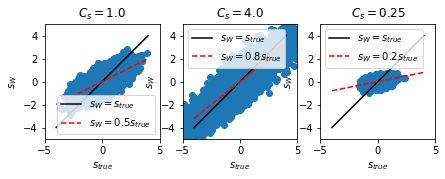

In [4]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
CS=1.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.figure(figsize=(7,7)) 
plt.subplot(131)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_W=s_{true}$')
plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.axis([-5,5,-5,5])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_W$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Higher CS
sarr=[]
weiner=[]
CS=4.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(132)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.axis([-5,5,-5,5])
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_W=s_{true}$')
plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_W$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Lower CS
sarr=[]
weiner=[]
CS=.25
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(133)
plt.axis([-5,5,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_W=s_{true}$')
plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_W$')
plt.title('$C_s=$'+str(CS))
plt.legend()

-0.012337227072585525 0.44904377563100534 0.5010648274277341


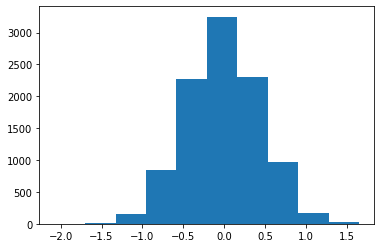

In [5]:
weiner=np.array(weiner)
sarr=np.array(sarr)
diff=weiner-sarr
plt.hist(diff)
print(np.mean(diff),np.std(diff),np.std(sarr))

This is odd: $s_W$ is the maximum posterior of the signal, the most likely value of the signal given the data ... and yet it appears biased: it gives the wrong expected value for the signal. In fact, it appears that simply using the data itself as an estimator would do better. Let's check that

-0.03303932209048627 1.0318666629285675 0.5115723962475327


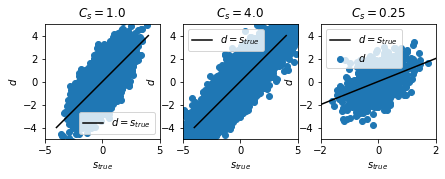

In [6]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
CS=1.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.figure(figsize=(7,7)) 
ax=plt.subplot(131)
plt.axis([-5,5,-5,5])
#ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$d=s_{true}$')
#plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$d$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Higher CS
sarr=[]
weiner=[]
CS=4.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(132)
plt.axis([-5,5,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$d=s_{true}$')
#plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$d$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Lower CS
sarr=[]
weiner=[]
CS=.25
narr=[]
for i in range(1000):
    n=np.random.normal()
    #print(n)
    narr.append(n)
    s=np.sqrt(CS)*np.random.normal()
    #print(s/np.sqrt(CS))
    sarr.append(s)
    d=s+n
    w=CS/(1.+CS)
    weiner.append(d)
weiner=np.array(weiner)
sarr=np.array(sarr)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(133)
plt.axis([-2,2,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(.4) #sets the height to width ratio to 1.5. 
#plt.scatter(sarr,weiner-sarr,label='$d-s$')  
plt.scatter(sarr,weiner,label='$d$')  
plt.plot([-4,4],[-4,4],'-k',label='$d=s_{true}$')
#plt.plot([-4,4],[-4*CS/(1.+CS),4*CS/(1.+CS)],'--r',label='$s_W=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$d$')
plt.title('$C_s=$'+str(CS))
plt.legend()
diff=weiner-sarr
print(np.mean(diff),np.std(diff),np.std(sarr))


This is interesting in that $\langle d\rangle \ne s$ as you might expect. Also, the contours are tilted in the opposite direction of the Weiner filter. It even seems like taking the square root of the Weiner filter would do better.

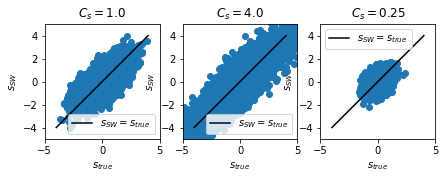

In [7]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
CS=1.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=np.sqrt(CS/(1.+CS))
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
plt.figure(figsize=(7,7)) 
plt.subplot(131)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_{SW}=s_{true}$')
#plt.plot([-4,4],[-4*w,4*w],'--r',label='$s_{SW}=$'+str(w)+'$s_{true}$')
plt.axis([-5,5,-5,5])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{SW}$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Higher CS
sarr=[]
weiner=[]
CS=4.
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=np.sqrt(CS/(1.+CS))
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(132)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.axis([-5,5,-5,5])
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_{SW}=s_{true}$')
#plt.plot([-4,4],[-4*w,4*w],'--r',label='$s_{SW}=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{SW}$')
plt.title('$C_s=$'+str(CS))
plt.legend()

### Lower CS
sarr=[]
weiner=[]
CS=.25
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    w=np.sqrt(CS/(1.+CS))
    weiner.append(d*w)
#plt.plot([1, 2, 3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.figure(figsize=(7,7)) 
plt.subplot(133)
plt.axis([-5,5,-5,5])
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1.) #sets the height to width ratio to 1.5. 
plt.scatter(sarr,weiner)  
plt.plot([-4,4],[-4,4],'-k',label='$s_{SW}=s_{true}$')
#plt.plot([-4,4],[-4*w,4*w],'--r',label='$s_{SW}=$'+str(w)+'$s_{true}$')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{SW}$')
plt.title('$C_s=$'+str(CS))
plt.legend()

So we have this odd situation, where the maximum posterior solution does not match the input signal when averaging over noise; the expectation is if you {\it correct} that by unmultiplying by the Weiner filer, you would get the correct signal back, but instead you end up over-correcting. And then, if you choose the middle path of the square root of the Weiner filter, you actually get an unbiased result.

At this point, it might be helpful to look at histograms of these estimators to see how large the spread is. Let's focus only on the low signal to noise case.

Text(0.5, 0, '$s_{true}$')

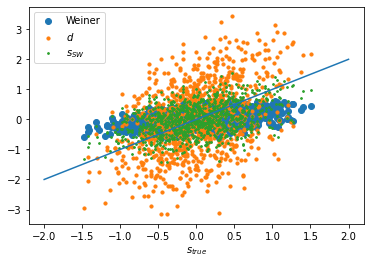

In [8]:
np.random.seed(seed=41)
sarr=[]
weiner=[]
sqweiner=[]
data=[]
CS=.25
for i in range(1000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    data.append(d)
    w=d*CS/(1.+CS)
    sw=d*np.sqrt(CS/(1.+CS))
    weiner.append(w)
    sqweiner.append(sw)
plt.scatter(sarr,weiner,label='Weiner')
plt.scatter(sarr,data,label='$d$',s=10)
plt.scatter(sarr,sqweiner,label='$s_{SW}$',s=3)
plt.plot([-2,2],[-2,2])
plt.legend()
plt.xlabel('$s_{true}$')

1.0830123323477125 0.2124226600480661 0.3032090138626248


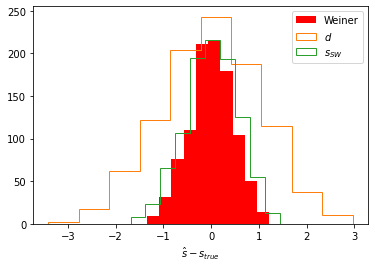

In [9]:
weiner=np.array(weiner)
sqweiner=np.array(sqweiner)
data=np.array(data)
sarr=np.array(sarr)
dw=weiner-sarr
dd=data-sarr
dsw=sqweiner-sarr
plt.hist(dw,facecolor='r',label='Weiner')
plt.hist(dd,histtype='step',facecolor='blue',label='$d$')
plt.hist(dsw,histtype='step',facecolor='k',label='$s_{SW}$')
plt.legend()
plt.xlabel('$\hat s-s_{true}$')
print(np.std(dd)**2,np.std(dw)**2,np.std(dsw)**2)

There it is: the variance of the Weiner filter is much lower than the variance of the data as an estimator. So, even though the data seems to track the signal better, as indicated by the figure above, the Weiner filter has a lower variance. Had you just guessed 0 for all signal draws, you would have gotten the correct mean and a variance of 0.25. So, even in the face of noise which is much larger than the signal, the Weiner filter gets a variance lower than the true variance. Just choosing the data as the estimator allows for very large signal, much larger than the prior would allow. So, the Weiner filter tells us that if you get a given data point, there is not that much that can be learned about the signal from that point. It is slightly informative, in that it reduces the variance of the difference between estimated and true from 0.25 to 0.21.

It might also be interesting to look at the correlation coefficient:
$$ r\equiv \frac{\hat s\cdot s_{True}}{[(\hat s)^2 (s_{True})^2]^{1/2}}$$

In [10]:
def r(hats,strue):
    num=np.dot(hats,strue)
    den=np.sqrt(np.dot(hats,hats)*np.dot(strue,strue))
    return num/den
print(np.shape(weiner),np.shape(sarr))
print(r(weiner[:,0],sarr[:,0]))
print(r(data[:,0],sarr[:,0]))
print(r(sqweiner[:,0],sarr[:,0]))
sdotn=np.dot(sarr[:,0],data[:,0]-sarr[:,0])/1000.
ssq=np.dot(sarr[:,0],sarr[:,0])/1000.
print((CS/(CS+1.))**.5)

(1000, 1) (1000, 1)
0.41292623214236995
0.41292623214236995
0.4129262321423702
0.4472135954999579


So the correlation between any of these estimators is the same. Any linear estimator (at least in this simple 1-pixel case) correlates the same with the truth. Note that the numerator and denominator differ: for the Weiner filter, the cross-correlation is small but so is the noise. But this implies that any linear map can be cross-correlated against a truth map and you would get the same signal to noise.

### Weiner Filter Map
Now consider multiple pixels all with the same signal and noise properties. $$P(\{s\},C_s|\{d\},C_n) \propto \, (2\pi C_s)^{-N/2}\, \exp\left\{-\frac12 \frac{\sum_{i=1}^N\ [d_i-s_i]^2}{C_n} \right\}
e^{-\sum_i\, s_i^2/2C_s}.
$$
Let's first consider the case where $C_s$ is known (as is $C_n$). We still have
$$ s_{W,i} = \frac{C_s}{C_s+C_n}\, d_i .$$

Both signal and noise are drawn from a Gaussian distribution. We can see analytically that the expected value of $s_{Weiner}$ is
$$ \langle s_W \rangle_N = \frac{C_s}{C_s+C_n}\, s_{true}. $$
where the subscript $N$ denotes an average over all noise realizations, but keeping $s$ fixed. So nothing changes. All the above results hold.

## Machine Learning

Take the above 1000 points and use them as test data, first training on a large set of pairs.

In [11]:
X_test=data
y_test=sarr
CS=.25
X_train=[]
y_train=[]
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.sqrt(CS)*np.random.normal(size=1)
    y_train.append(s)
    d=s+n
    X_train.append(d)
X_train=np.array(X_train)
y_train=np.array(y_train)
    


In [12]:
# Simplest is just to do regression.
from sklearn.linear_model import LinearRegression
lin_reg=LinearRegression()
lin_reg.fit(X_train,y_train)
regfit=lin_reg.predict(X_test)

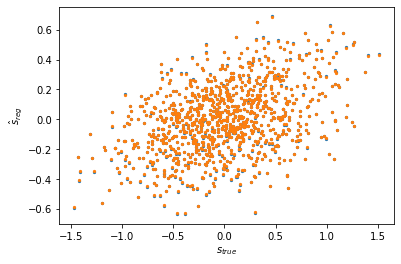

In [69]:
plt.scatter(y_test,regfit,s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s_{reg}$')
plt.scatter(y_test,weiner,s=5)

0.16862274078671924 0.2124226600480661


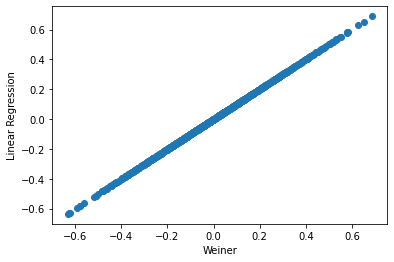

In [54]:
plt.scatter(weiner, regfit)
plt.xlabel('Weiner')
plt.ylabel('Linear Regression')
print(lin_reg.score(X_test,y_test),np.std(dw)**2)
#The coefficient of determination  is defined as (1-u/v) 
#where u is the residual sum of squares ((y_true - y_pred)** 2).sum() 
# and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()
## In this case v=C_sN and u=0.21N, so 

So, the linear regression is equivalent to the Weiner filter. In some sense this is not surprising, as the Weiner filter minimizes the argument of the exponential, thereby producing a linear fit that minimizes the cost function. The cost function here $$(s-\hat s)^2$$ is proportional to the exponential of the likelihood, so it makes sense that this gives the same answer as the Weiner filter.

In [80]:
# Now try a neural net
#import tensorflow as tf
from tensorflow import keras
model=keras.models.Sequential()

In [81]:
model.add(keras.layers.Dense(1,activation ='tanh',input_shape=[1]))
#model.add(keras.layers.Dense(1,activation ='softmax'))

In [82]:
model.compile(loss='mse')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [83]:
history=model.fit(X_train,y_train,epochs=30)

Epoch 1/30
313/313 [==============================] - 0s 356us/step - loss: 0.7248
Epoch 2/30
313/313 [==============================] - 0s 344us/step - loss: 0.4695
Epoch 3/30
313/313 [==============================] - 0s 324us/step - loss: 0.2587
Epoch 4/30
313/313 [==============================] - 0s 325us/step - loss: 0.2040
Epoch 5/30
313/313 [==============================] - 0s 320us/step - loss: 0.2032
Epoch 6/30
313/313 [==============================] - 0s 324us/step - loss: 0.2032
Epoch 7/30
313/313 [==============================] - 0s 325us/step - loss: 0.2032
Epoch 8/30
313/313 [==============================] - 0s 320us/step - loss: 0.2032
Epoch 9/30
313/313 [==============================] - 0s 325us/step - loss: 0.2032
Epoch 10/30
313/313 [==============================] - 0s 314us/step - loss: 0.2032
Epoch 11/30
313/313 [==============================] - 0s 320us/step - loss: 0.2032
Epoch 12/30
313/313 [==============================] - 0s 317us/step - loss: 0.2031
E

In [85]:
weights,biases=model.get_weights()
print(weights,biases)
print('CNN Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

[[0.20914878]] [-0.00040216]
CNN Score
0.21289082341813576
Regression Score
0.2124868451039727


These are both -- within errors -- equal to the "loss function" of the Weiner filter. If anything, the CNN is slightly worse.

<Figure size 792x576 with 0 Axes>

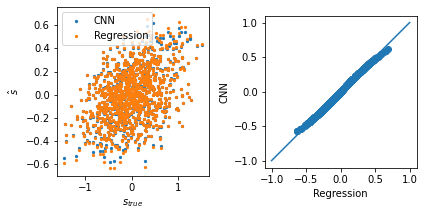

In [105]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,model.predict(X_test),label='CNN',s=5)
ax[0].set_aspect(2.5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=5)
plt.legend()
plt.subplot(122)
ax[1].scatter(regfit,model.predict(X_test))
ax[1].set_aspect(1)
plt.ylabel('CNN')
plt.xlabel('Regression')
ax[1].plot([-1,1],[-1,1])
fig.tight_layout()

So CNN allows for nonlinearity, hence slightly lower values of $\hat s$ in amplitude, but no change in score.

In [106]:
# Try one with more nodes
m1=keras.models.Sequential()
m1.add(keras.layers.Dense(10,activation ='tanh',input_shape=[1]))
m1.add(keras.layers.Dense(1,activation ='tanh',input_shape=[1]))
m1.compile(loss='mse')
history=m1.fit(X_train,y_train,epochs=30)

Epoch 1/30
313/313 [==============================] - 0s 438us/step - loss: 0.2090
Epoch 2/30
313/313 [==============================] - 0s 408us/step - loss: 0.2047
Epoch 3/30
313/313 [==============================] - 0s 396us/step - loss: 0.2042
Epoch 4/30
313/313 [==============================] - 0s 374us/step - loss: 0.2038
Epoch 5/30
313/313 [==============================] - 0s 358us/step - loss: 0.2038
Epoch 6/30
313/313 [==============================] - 0s 358us/step - loss: 0.2037
Epoch 7/30
313/313 [==============================] - 0s 374us/step - loss: 0.2037
Epoch 8/30
313/313 [==============================] - 0s 358us/step - loss: 0.2035
Epoch 9/30
313/313 [==============================] - 0s 360us/step - loss: 0.2037
Epoch 10/30
313/313 [==============================] - 0s 350us/step - loss: 0.2035
Epoch 11/30
313/313 [==============================] - 0s 352us/step - loss: 0.2036
Epoch 12/30
313/313 [==============================] - 0s 350us/step - loss: 0.2035
E

CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

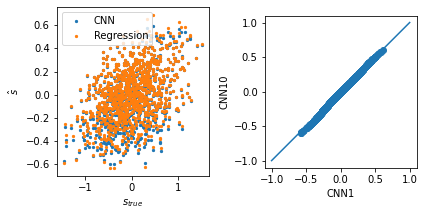

In [119]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,m1.predict(X_test),label='CNN',s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=5)
ax[0].set_aspect(2.5)
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),m1.predict(X_test))
plt.ylabel('CNN10')
plt.xlabel('CNN1')
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

One thing that the CNN's have that the Weiner filter does not is: they are not given $C_s$ or $C_n$, so the fact that they do as well is heartening. Would it make any difference if multiple samples were used as a single data set?

In [128]:
np.random.seed(seed=42)
X_train=[]
y_train=[]
for i in range(1000):
    n=np.random.normal(size=1000)
    s=np.sqrt(CS)*np.random.normal(size=1000)
    y_train.append(s)
    d=s+n
    X_train.append(d)
X_train=np.array(X_train)
y_train=np.array(y_train)
print(np.shape(X_train),np.shape(y_train),y_test.shape)
print(X_train.shape[1:],X_test.shape)

(1000, 1000) (1000, 1000) (1000, 1)
(1000,) (1000, 1)


In [168]:
mmap=keras.models.Sequential([keras.layers.Dense(1000,activation="tanh",input_shape=X_train.shape[1:]),
                             keras.layers.Dense(300,activation="tanh"),
                              keras.layers.Dense(1000)])
mmap.compile(loss="mse")
history=mmap.fit(X_train,y_train,epochs=40)


Epoch 1/40
32/32 [==============================] - 1s 14ms/step - loss: 0.3535
Epoch 2/40
32/32 [==============================] - 0s 14ms/step - loss: 0.2451
Epoch 3/40
32/32 [==============================] - 0s 13ms/step - loss: 0.2114
Epoch 4/40
32/32 [==============================] - 0s 12ms/step - loss: 0.1921
Epoch 5/40
32/32 [==============================] - 0s 12ms/step - loss: 0.1780
Epoch 6/40
32/32 [==============================] - 0s 12ms/step - loss: 0.1662
Epoch 7/40
32/32 [==============================] - 0s 12ms/step - loss: 0.1566
Epoch 8/40
32/32 [==============================] - 0s 13ms/step - loss: 0.1488
Epoch 9/40
32/32 [==============================] - 0s 13ms/step - loss: 0.1420
Epoch 10/40
32/32 [==============================] - 0s 12ms/step - loss: 0.1366
Epoch 11/40
32/32 [==============================] - 0s 12ms/step - loss: 0.1318
Epoch 12/40
32/32 [==============================] - 0s 12ms/step - loss: 0.1277
Epoch 13/40
32/32 [==================

In [169]:
print(np.shape(X_test),np.shape(X_train))
X_t=tf.reshape(X_test,(-1,1000))
#X_test.reshape(-1,1000)
print(np.shape(X_t))
mappredict=mmap.predict(X_t)
print(mappredict.shape,y_test.shape)

(1000, 1) (1000, 1000)
(1, 1000)
(1, 1000) (1000, 1)


CNNmap Score
0.40647771669500093
CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

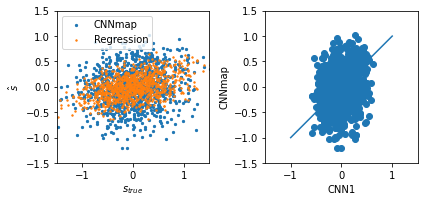

In [175]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,mmap.predict(X_t),label='CNNmap',s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=2)
ax[0].set_aspect(1)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),mmap.predict(X_t))
plt.ylabel('CNNmap')
plt.xlabel('CNN1')
plt.axis([-1.5,1.5,-1.5,1.5])
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNNmap Score')
print(np.std(mmap.predict(X_t)-y_test)**2)
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

In [177]:
mmap.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_32 (Dense)             (None, 300)               300300    
_________________________________________________________________
dense_33 (Dense)             (None, 1000)              301000    
Total params: 1,602,300
Trainable params: 1,602,300
Non-trainable params: 0
_________________________________________________________________


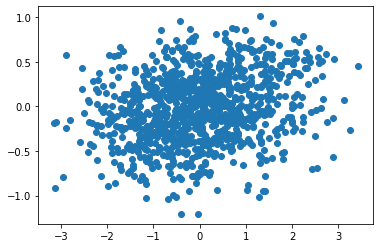

In [178]:
plt.scatter(X_test,mappredict)

So the estimator is slightly correlated with the data, but the score is quite bad and the number of parameters is huge. Try fewer.

In [180]:
mmap1=keras.models.Sequential([keras.layers.Dense(10,activation="tanh",input_shape=X_train.shape[1:]),
                             keras.layers.Dense(30,activation="tanh"),
                              keras.layers.Dense(1000)])
mmap1.compile(loss="mse")
history=mmap1.fit(X_train,y_train,epochs=40)


Epoch 1/40
32/32 [==============================] - 0s 773us/step - loss: 0.2557
Epoch 2/40
32/32 [==============================] - 0s 662us/step - loss: 0.2506
Epoch 3/40
32/32 [==============================] - 0s 676us/step - loss: 0.2489
Epoch 4/40
32/32 [==============================] - 0s 690us/step - loss: 0.2480
Epoch 5/40
32/32 [==============================] - 0s 637us/step - loss: 0.2473
Epoch 6/40
32/32 [==============================] - 0s 631us/step - loss: 0.2468
Epoch 7/40
32/32 [==============================] - 0s 618us/step - loss: 0.2464
Epoch 8/40
32/32 [==============================] - 0s 613us/step - loss: 0.2460
Epoch 9/40
32/32 [==============================] - 0s 615us/step - loss: 0.2457
Epoch 10/40
32/32 [==============================] - 0s 660us/step - loss: 0.2455
Epoch 11/40
32/32 [==============================] - 0s 638us/step - loss: 0.2453
Epoch 12/40
32/32 [==============================] - 0s 627us/step - loss: 0.2451
Epoch 13/40
32/32 [======

CNNmap1 Score
0.263595120307505
CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

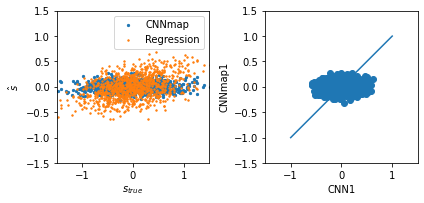

In [181]:
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,mmap1.predict(X_t),label='CNNmap',s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=2)
ax[0].set_aspect(1)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),mmap1.predict(X_t))
plt.ylabel('CNNmap1')
plt.xlabel('CNN1')
plt.axis([-1.5,1.5,-1.5,1.5])
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNNmap1 Score')
print(np.std(mmap1.predict(X_t)-y_test)**2)
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

In [182]:
mmap1.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_38 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_39 (Dense)             (None, 1000)              31000     
Total params: 41,340
Trainable params: 41,340
Non-trainable params: 0
_________________________________________________________________


So 2 layers 10x30 before the last layer leads to a better score [but still worse than simple CNN] Still a lot of parameters, and the output is oriented much differently than the 1000x300; the latter was vertical in the second plot compared to this one which is horizontal, essentially, predicting very small signal all the time.

In [183]:
mmap2=keras.models.Sequential([keras.layers.Dense(10,activation="relu",input_shape=X_train.shape[1:]),
                             keras.layers.Dense(30,activation="tanh"),
                              keras.layers.Dense(1000)])
mmap2.compile(loss="mse")
history=mmap2.fit(X_train,y_train,epochs=40)

Epoch 1/40
32/32 [==============================] - 0s 841us/step - loss: 0.2577
Epoch 2/40
32/32 [==============================] - 0s 735us/step - loss: 0.2512
Epoch 3/40
32/32 [==============================] - 0s 623us/step - loss: 0.2497
Epoch 4/40
32/32 [==============================] - 0s 656us/step - loss: 0.2488
Epoch 5/40
32/32 [==============================] - 0s 608us/step - loss: 0.2481
Epoch 6/40
32/32 [==============================] - 0s 637us/step - loss: 0.2476
Epoch 7/40
32/32 [==============================] - 0s 632us/step - loss: 0.2471
Epoch 8/40
32/32 [==============================] - 0s 631us/step - loss: 0.2468
Epoch 9/40
32/32 [==============================] - 0s 688us/step - loss: 0.2465
Epoch 10/40
32/32 [==============================] - 0s 620us/step - loss: 0.2463
Epoch 11/40
32/32 [==============================] - 0s 658us/step - loss: 0.2460
Epoch 12/40
32/32 [==============================] - 0s 635us/step - loss: 0.2459
Epoch 13/40
32/32 [======

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_41 (Dense)             (None, 30)                330       
_________________________________________________________________
dense_42 (Dense)             (None, 1000)              31000     
Total params: 41,340
Trainable params: 41,340
Non-trainable params: 0
_________________________________________________________________
CNNmap1 Score
0.2664703267703526
CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

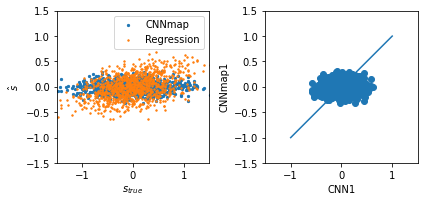

In [184]:
mmap2.summary()
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,mmap2.predict(X_t),label='CNNmap',s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=2)
ax[0].set_aspect(1)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),mmap2.predict(X_t))
plt.ylabel('CNNmap1')
plt.xlabel('CNN1')
plt.axis([-1.5,1.5,-1.5,1.5])
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNNmap1 Score')
print(np.std(mmap2.predict(X_t)-y_test)**2)
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

So changing the activation function of the first layerdoesn't do anything.

In [185]:
# Try even fewer parameters
mmap3=keras.models.Sequential([keras.layers.Dense(1,activation="relu",input_shape=X_train.shape[1:]),
                             keras.layers.Dense(3,activation="tanh"),
                              keras.layers.Dense(1000)])
mmap3.compile(loss="mse")
history=mmap3.fit(X_train,y_train,epochs=40)

Epoch 1/40
32/32 [==============================] - 0s 654us/step - loss: 0.2508
Epoch 2/40
32/32 [==============================] - 0s 542us/step - loss: 0.2502
Epoch 3/40
32/32 [==============================] - 0s 557us/step - loss: 0.2500
Epoch 4/40
32/32 [==============================] - 0s 545us/step - loss: 0.2499
Epoch 5/40
32/32 [==============================] - 0s 556us/step - loss: 0.2498
Epoch 6/40
32/32 [==============================] - 0s 546us/step - loss: 0.2498
Epoch 7/40
32/32 [==============================] - 0s 545us/step - loss: 0.2497
Epoch 8/40
32/32 [==============================] - 0s 538us/step - loss: 0.2497
Epoch 9/40
32/32 [==============================] - 0s 537us/step - loss: 0.2497
Epoch 10/40
32/32 [==============================] - 0s 546us/step - loss: 0.2496
Epoch 11/40
32/32 [==============================] - 0s 539us/step - loss: 0.2496
Epoch 12/40
32/32 [==============================] - 0s 531us/step - loss: 0.2496
Epoch 13/40
32/32 [======

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 1)                 1001      
_________________________________________________________________
dense_44 (Dense)             (None, 3)                 6         
_________________________________________________________________
dense_45 (Dense)             (None, 1000)              4000      
Total params: 5,007
Trainable params: 5,007
Non-trainable params: 0
_________________________________________________________________
CNNmap3 Score
0.25613335449969676
CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

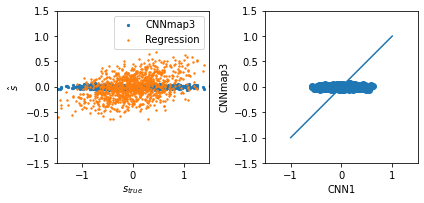

In [186]:
mmap3.summary()
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,mmap3.predict(X_t),label='CNNmap3',s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=2)
ax[0].set_aspect(1)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),mmap3.predict(X_t))
plt.ylabel('CNNmap3')
plt.xlabel('CNN1')
plt.axis([-1.5,1.5,-1.5,1.5])
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNNmap3 Score')
print(np.std(mmap3.predict(X_t)-y_test)**2)
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

So it looks like the fewer parameters you use, the smaller the predicted signal. Try an intermediate amount.

In [187]:
# Try even fewer parameters
mmap4=keras.models.Sequential([keras.layers.Dense(1000,activation="relu",input_shape=X_train.shape[1:]),
                             keras.layers.Dense(30,activation="tanh"),
                              keras.layers.Dense(1000)])
mmap4.compile(loss="mse")
history=mmap4.fit(X_train,y_train,epochs=40)

Epoch 1/40
32/32 [==============================] - 1s 9ms/step - loss: 0.2673
Epoch 2/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2523
Epoch 3/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2465
Epoch 4/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2441
Epoch 5/40
32/32 [==============================] - 0s 9ms/step - loss: 0.2419
Epoch 6/40
32/32 [==============================] - 0s 9ms/step - loss: 0.2402
Epoch 7/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2387
Epoch 8/40
32/32 [==============================] - 0s 9ms/step - loss: 0.2376
Epoch 9/40
32/32 [==============================] - 0s 9ms/step - loss: 0.2367
Epoch 10/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2360
Epoch 11/40
32/32 [==============================] - 0s 9ms/step - loss: 0.2354
Epoch 12/40
32/32 [==============================] - 0s 9ms/step - loss: 0.2349
Epoch 13/40
32/32 [=========================

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_47 (Dense)             (None, 30)                30030     
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              31000     
Total params: 1,062,030
Trainable params: 1,062,030
Non-trainable params: 0
_________________________________________________________________
CNN4 Score
0.2664208608616744
CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

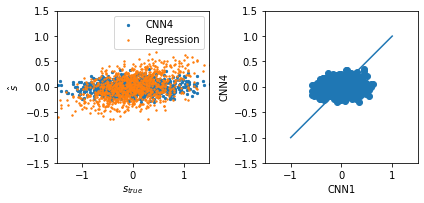

In [189]:
m=mmap4
version='4'
m.summary()
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,m.predict(X_t),label='CNN'+version,s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=2)
ax[0].set_aspect(1)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),m.predict(X_t))
plt.ylabel('CNN'+version)
plt.xlabel('CNN1')
plt.axis([-1.5,1.5,-1.5,1.5])
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNN'+version+' Score')
print(np.std(m.predict(X_t)-y_test)**2)
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

still too horizontal; increase the number of neurons in the hidden layer

In [190]:
mmap5=keras.models.Sequential([keras.layers.Dense(1000,activation="relu",input_shape=X_train.shape[1:]),
                             keras.layers.Dense(100,activation="tanh"),
                              keras.layers.Dense(1000)])
mmap5.compile(loss="mse")
history=mmap5.fit(X_train,y_train,epochs=40)

Epoch 1/40
32/32 [==============================] - 1s 10ms/step - loss: 0.2869
Epoch 2/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2531
Epoch 3/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2499
Epoch 4/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2490
Epoch 5/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2470
Epoch 6/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2446
Epoch 7/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2414
Epoch 8/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2375
Epoch 9/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2334
Epoch 10/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2289
Epoch 11/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2243
Epoch 12/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2202
Epoch 13/40
32/32 [==================

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_50 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_51 (Dense)             (None, 1000)              101000    
Total params: 1,202,100
Trainable params: 1,202,100
Non-trainable params: 0
_________________________________________________________________
CNN5 Score
0.29259845696021064
CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

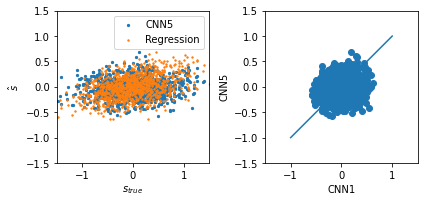

In [191]:
m=mmap5
version='5'
m.summary()
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,m.predict(X_t),label='CNN'+version,s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=2)
ax[0].set_aspect(1)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),m.predict(X_t))
plt.ylabel('CNN'+version)
plt.xlabel('CNN1')
plt.axis([-1.5,1.5,-1.5,1.5])
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNN'+version+' Score')
print(np.std(m.predict(X_t)-y_test)**2)
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

That seems kind of odd: they both have the same slope wrt true but the second plot indicates that they are apparently uncorrelated with one another.

Text(0, 0.5, '$\\hat s$')

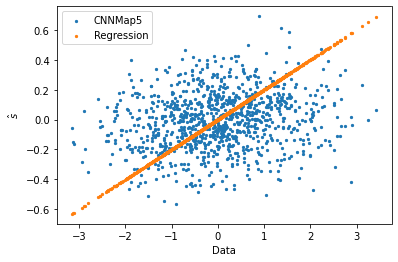

In [194]:
plt.scatter(X_test,m.predict(X_t),s=5,label='CNNMap5')
plt.scatter(X_test,regfit,s=5,label='Regression')
plt.legend()
plt.xlabel('Data')
plt.ylabel('$\hat s$')

So this CNN is not at all linear in the data but still manages to guess the signal a decent amount of the time? That makes sense: it is trained on data for which the same value of $d$ will give different values of $s$, so it accounts for this.

We know how to control the slope and we know that the slope of the regression/Weiner filter is off, so try to steepen the slope by adding more hidden layers?

In [195]:
mmap6=keras.models.Sequential([keras.layers.Dense(1000,activation="relu",input_shape=X_train.shape[1:]),
                             keras.layers.Dense(200,activation="tanh"),
                              keras.layers.Dense(1000)])
mmap6.compile(loss="mse")
history=mmap6.fit(X_train,y_train,epochs=40)

Epoch 1/40
32/32 [==============================] - 1s 12ms/step - loss: 0.3083
Epoch 2/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2612
Epoch 3/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2556
Epoch 4/40
32/32 [==============================] - 0s 12ms/step - loss: 0.2526
Epoch 5/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2491
Epoch 6/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2444
Epoch 7/40
32/32 [==============================] - 0s 10ms/step - loss: 0.2387
Epoch 8/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2322
Epoch 9/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2250
Epoch 10/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2171
Epoch 11/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2091
Epoch 12/40
32/32 [==============================] - 0s 11ms/step - loss: 0.2012
Epoch 13/40
32/32 [==================

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_53 (Dense)             (None, 200)               200200    
_________________________________________________________________
dense_54 (Dense)             (None, 1000)              201000    
Total params: 1,402,200
Trainable params: 1,402,200
Non-trainable params: 0
_________________________________________________________________
CNN6 Score
0.33004480274583065
CNN1 Score
0.21289082341813576
CNN10 Score
0.21323332827809005
Regression Score
0.2124868451039727


<Figure size 792x576 with 0 Axes>

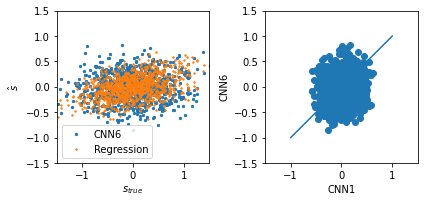

In [196]:
m=mmap6
version='6'
m.summary()
plt.figure(figsize=(11,8))
fig, ax = plt.subplots(1, 2)
plt.subplot(121)
ax[0].scatter(y_test,m.predict(X_t),label='CNN'+version,s=5)
plt.xlabel('$s_{true}$')
plt.ylabel('$\hat s$')
ax[0].scatter(y_test,regfit,label='Regression',s=2)
ax[0].set_aspect(1)
plt.axis([-1.5,1.5,-1.5,1.5])
plt.legend()
plt.subplot(122)
ax[1].scatter(model.predict(X_test),m.predict(X_t))
plt.ylabel('CNN'+version)
plt.xlabel('CNN1')
plt.axis([-1.5,1.5,-1.5,1.5])
ax[1].plot([-1,1],[-1,1])
ax[1].set_aspect(1)
fig.tight_layout()
print('CNN'+version+' Score')
print(np.std(m.predict(X_t)-y_test)**2)
print('CNN1 Score')
print(np.std(model.predict(X_test)-y_test)**2)
print('CNN10 Score')
print(np.std(m1.predict(X_test)-y_test)**2)
print('Regression Score')
print(np.std(regfit-y_test)**2)

Changing the slope wrt Weiner [right] does not seem to change the slope wrt true [left] although it does decrease the score by increasing the variance.

ValueError: x and y must be the same size

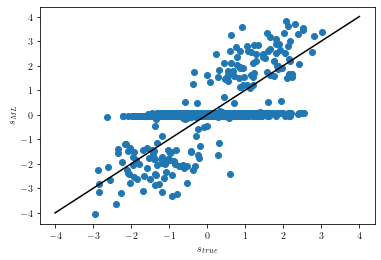

In [192]:
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
for i in range(1000):
    n=np.random.normal(size=1)
    s=np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d/2)
    x0=[1,2]
    fmin = op.minimize(log_prob,x0)
    tmp=fmin.x[0]
    rat.append(tmp/s)
    xml.append(tmp)
    tmp=fmin.x[1]
    csarr.append(tmp)
plt.scatter(sarr,xml,label='$C_s=1$')  
plt.plot([-4,4],[-4,4],'-k')
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{ML}$')
## Higher C_s
xml=[]
sarr1=[]
csarr1=[]
rat=[]
weiner1=[]
sigma=2.
for i in range(100):
    n=np.random.normal(size=1)
    s=sigma*np.random.normal(size=1)
    sarr1.append(s)
    d=s+n
    weiner1.append(d*4/5.)
    x0=[1,2]
    fmin = op.minimize(log_prob,x0)
    tmp=fmin.x[0]
    rat.append(tmp/s)
    xml.append(tmp)
    tmp=fmin.x[1]
    csarr1.append(tmp)
plt.scatter(sarr,xml,label='$C_s=4$') 
plt.axis([-4,4,-4,4])
plt.legend()
plt.savefig('ss.png')


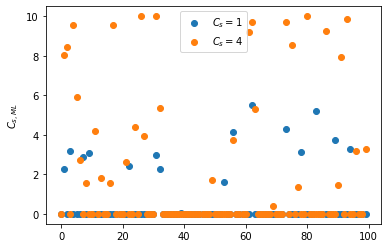

In [46]:
plt.scatter(range(100),csarr,label='$C_s=1$')
plt.scatter(range(100),csarr1,label='$C_s=4$')
plt.ylabel('$C_{s,ML}$')
plt.legend()
plt.savefig('cs.png')
#plt.plot([0,100],[4,4])

In [78]:
### The Weiner filter using the true value of $C_s$ is
## s=d/2 or 4d/5, so that the estimated power spectrum would 
##plt.scatter(rat,csarr)
print(np.mean(csarr))
print(np.mean(rat))

0.5020123987021704
0.4820168149900555


The Weiner filter using the true value of $C_s$ sets $s=d/2$ or $4d/5$ in the two cases above. Let's see how well this does in estimating the signal.

In [130]:
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
for i in range(10000):
    n=np.random.normal(size=1)
    s=np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d/2)
    

Text(0, 0.5, '$s_{Weiner}$')

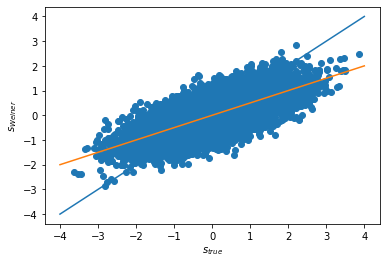

In [133]:
plt.scatter(sarr,weiner,label='$C_s=C_n$')
plt.plot([-4,4],[-4,4])
plt.plot([-4,4],[-2,2])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{Weiner}$')


It gets the slope wrong, obviously, with mean $\hat s=sC_s/C$. This is the point of maximum likelihood. However, it is interesting to plot the full likelihood.

In [134]:
##low CS
np.random.seed(seed=41)
xml=[]
sarr=[]
csarr=[]
rat=[]
weiner=[]
CS=.1**2
for i in range(10000):
    n=np.random.normal(size=1)
    s=.1*np.random.normal(size=1)
    sarr.append(s)
    d=s+n
    weiner.append(d*CS/(1.+CS))
    

Text(0, 0.5, '$s_{Weiner}$')

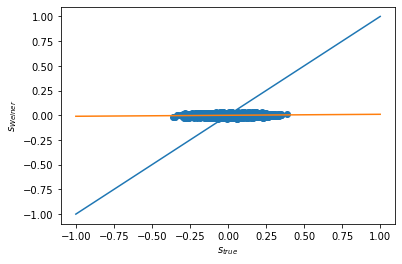

In [136]:
plt.scatter(sarr,weiner,label='$C_s=0.01C_n$')
plt.plot([-1,1],[-1,1])
plt.plot([-1,1],[-.01,.01])
plt.xlabel('$s_{true}$')
plt.ylabel('$s_{Weiner}$')


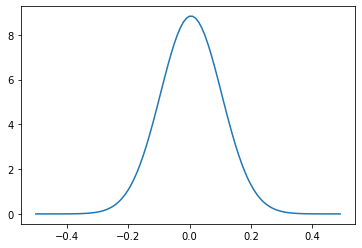

In [140]:
CN=1.
CS=.01
d=.5
def prob(x):
    s=x
    return CS**(-0.5)*np.exp(-0.5*s**2/CS - 0.5*(s-d)**2/CN)
xa=np.arange(-.5,.5,.01)
plt.plot(xa,prob(xa))

The product of 2 gaussians is a gaussian but the peak of the ensuing gaussian is in between $d$ and $0$. In real life the signal can be larger than the data when the noise is negative, but the Weiner filter does not allow for this. So, the maximum likelihood is skewed low.

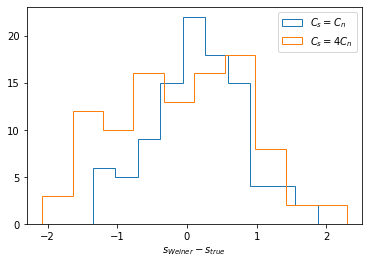

In [105]:
weiner=np.array(weiner)
sarr=np.array(sarr)
weiner1=np.array(weiner1)
sarr1=np.array(sarr1)
plt.hist(weiner-sarr,histtype='step',label='$C_s=C_n$')
plt.hist(weiner1-sarr1,label='$C_s=4C_n$',histtype='step')
plt.legend()
plt.xlabel('$s_{Weiner}-s_{true}$')
plt.savefig('swein.png')

This means that the estimated power spectrum in these two cases would be $d^2 [1/4,16/25]$. We can do a histogram of those predictions.

0.5297018979270384 0.7342915517167761


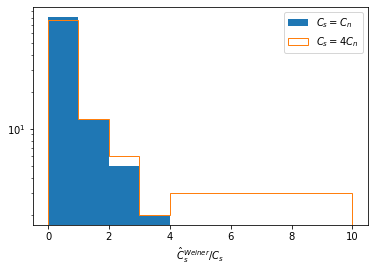

In [112]:
weiner=np.array(weiner)
wbins=[0,1,2,3,4,10]
plt.hist(weiner**2,bins=wbins,label='$C_s=C_n$')
weiner1=np.array(weiner1)
plt.hist(weiner1**2/4,histtype='step',bins=wbins,label='$C_s=4C_n$')
plt.yscale('log')
plt.xlabel('$\hat C_s^{Weiner}/C_s$')
plt.savefig('wpow.png')
plt.legend()
print(np.mean(weiner**2),np.mean(weiner1**2)/4.)

The correct way to estimate the power is to use: $\hat C_s=d^2-C_n$. We can see how well that does here.

1.1188075917081535 0.8973305495574629


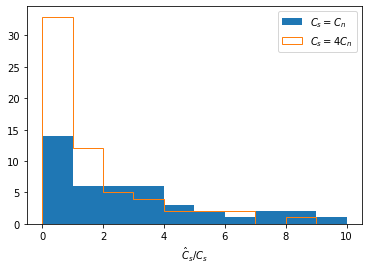

In [115]:
wbins=[0,1,2,3,4,5,6,7,8,9,10]
pow0=weiner**2*4-1.
plt.hist(pow0,bins=wbins,label='$C_s=C_n$')
pow1=((25./16)*weiner1**2-1.)/4
plt.hist(pow1,histtype='step',bins=wbins,label='$C_s=4C_n$')
#plt.yscale('log')
plt.xlabel('$\hat C_s/C_s$')
plt.legend()
plt.savefig('pow.png')
print(np.mean(pow0),np.mean(pow1))

In [3]:
nwalkers = 32
ndim=2
CN=1.
d=1.
p0 = np.zeros((nwalkers,ndim))#[d,CN]
np.random.seed(42)
p0[:,0]=d + np.random.rand(nwalkers)
p0[:,1]=CN + .2*np.random.rand(nwalkers)
print(np.shape(p0))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[d,CN])


(32, 2)


In [96]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [97]:
sampler.run_mcmc(state,100000);

None


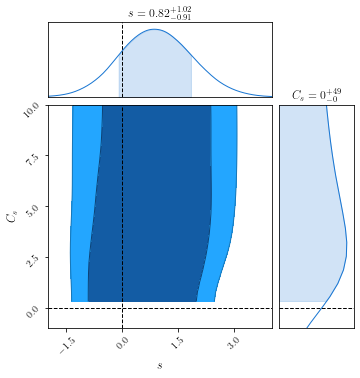

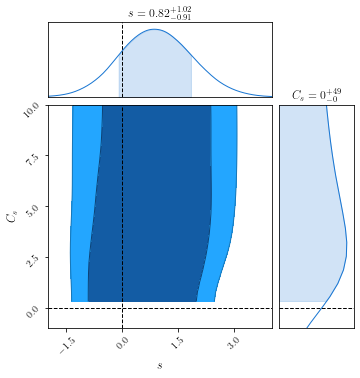

In [100]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["$s$", "$C_s$"],walkers=32)
print(c.analysis.get_max_posteriors(parameters=["$s$", "$C_s$"]))
#c.add_marker(location=[1,4],marker_style='X',marker_size=40)
c.plotter.plot(filename="l1.png", extents=[(-2,4),(-1,10)],figsize="column",truth=[0,0],legend=None)


In [92]:
estp=.5*(d**2-2. + d*np.sqrt(d**2-4.))
print(estp)
estm=.5*(d**2-2. - d*np.sqrt(d**2-4.))
print(estm)

print(log_prob((np.sqrt(estp),estp), d, CN))
print(log_prob((np.sqrt(estm),estm), d, CN))
print(log_prob((2.38,6.1), d, CN))
print(d**2-CN)

4.0
0.25
-1.3181471805599454
-1.8068528194400546
-1.375639467556846
5.25


In [133]:
np.random.seed(seed=42)
n=np.random.normal(size=2)
s=np.random.normal(size=2)
d=s+n
print(d)

[1.14440269 1.38476556]


In [58]:
CN=1.
def log_2dprob(x, d):
    s=x[:2]
    CS=x[2]
    if CS <= .0001 or CS >= 10.:
        return -100
    else:
        return -0.5*np.log(CS**2) - 0.5*np.dot(s,s)/CS - 0.5*np.dot((s-d),s-d)/CN
def log_2dprob_minus(x, d):
    s=x[:2]
    CS=x[2]
    if CS <= .0001 or CS >= 10.:
        return 100
    else:
        return 0.5*np.log(CS**2) + 0.5*np.dot(s,s)/CS + 0.5*np.dot((s-d),s-d)/CN


In [182]:
nwalkers = 32
ndim=3
p0 = np.zeros((nwalkers,ndim))#[d,CN]
np.random.seed(42)
p0[:,0]=np.random.rand(nwalkers)
p0[:,1]=np.random.rand(nwalkers)
p0[:,2]=(1.+.01*np.random.rand(nwalkers))
print(p0[:,2])
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_2dprob, args=[d])
state = sampler.run_mcmc(p0, 100)
sampler.reset()

[1.00280935 1.00542696 1.00140924 1.00802197 1.00074551 1.00986887
 1.00772245 1.00198716 1.00005522 1.00815461 1.00706857 1.00729007
 1.0077127  1.00074045 1.00358466 1.00115869 1.00863103 1.00623298
 1.00330898 1.00063558 1.00310982 1.00325183 1.00729606 1.00637557
 1.00887213 1.00472215 1.00119594 1.00713245 1.00760785 1.00561277
 1.00770967 1.00493796]


In [183]:
sampler.run_mcmc(state,200000)

State([[ 3.35853062e+00  2.48791596e+00  5.86741943e+00]
 [ 2.39582628e+00  1.28981547e+00  2.63513523e+00]
 [ 7.44097104e-01  1.25542905e+00  2.29433541e+00]
 [-1.22712798e+00  2.25121847e-01  9.09531895e+00]
 [ 5.60283694e-01  1.41319535e+00  6.28078096e+00]
 [-1.39553351e+00  7.11698922e-01  1.57488414e+00]
 [ 2.97036050e-01  1.38774705e-01  1.26395094e-01]
 [ 2.48696118e+00 -3.24166978e-01  5.11380040e+00]
 [-5.29975450e-01 -3.58720423e-01  5.29420553e+00]
 [-4.08380155e-02  4.11251361e-01  1.31068590e+00]
 [ 4.40944949e-01 -2.24412254e-01  6.25021234e-01]
 [ 3.96230802e-01  4.87225208e-01  3.33796528e+00]
 [ 1.19404224e+00  1.47897187e+00  7.54433587e+00]
 [ 4.97111793e-01  2.22713067e+00  2.48105284e+00]
 [ 1.28098319e+00  6.28312478e-01  5.85261286e+00]
 [ 9.54488952e-01  6.69067239e-01  9.93746150e+00]
 [ 2.05202186e-01  8.96009293e-01  7.95814953e+00]
 [ 9.85860306e-01  6.94313059e-01  4.17407700e+00]
 [ 6.19024716e-01 -1.80983187e-02  9.13892467e-01]
 [ 7.05525552e-01  9.6919

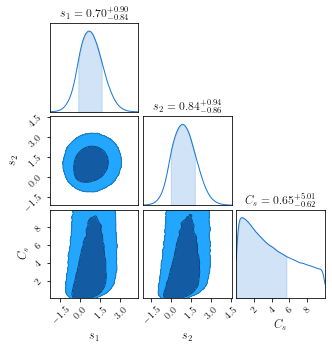

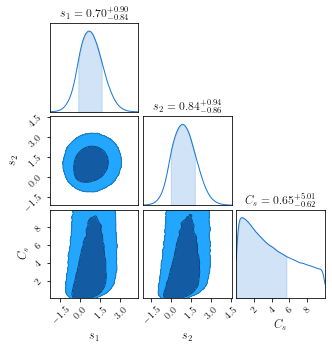

In [187]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
c = ChainConsumer()
c.add_chain(flat_samples, parameters=["$s_1$", "$s_2$","$C_s$"])
maxp=[d[0]/2.,d[1]/2.,1.]
c.plotter.plot(filename="3d.png")#,truth=maxp)#,figsize="column",truth=[0,0],legend=None)


In [60]:
print(d)
bard=0.5*np.dot(d,d)
print(bard)
#estp=.5*(bard**2-2. + bard*np.sqrt(bard**2-4.))
#print(estp)
#estm=.5*(bard**2-2. - bard*np.sqrt(bard**2-4.))
#print(estm)

print(log_2dprob([0.,0.,.011], d))
print(log_2dprob([0.7,0.84,.65], d))
#print(log_prob((np.sqrt(estm),estm), d, CN))
#print(log_prob((2.38,6.1), d, CN))


[2.36109278]
2.787379554801199
-1.0648991034186315
-3.0253856220130206


In [77]:
x0=[.1,.1,.5]
fmin = op.minimize((log_2dprob_minus),x0,args=d)#,method='Powell')
print(fmin)

      fun: -0.5144597248001181
 hess_inv: array([[4.17161790e-02, 2.41373667e-01, 1.74189249e-03],
       [2.41373667e-01, 1.44311916e+00, 1.03876928e-02],
       [1.74189249e-03, 1.03876928e-02, 7.47887401e-05]])
      jac: array([   154.79857302,    185.89691752, -20538.55127841])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 381
      nit: 15
     njev: 93
   status: 2
  success: False
        x: array([0.01650379, 0.01976951, 0.00010502])


In [67]:
print(log_2dprob_minus([1.80800108, 1.80799628, 3.26890828],d))
print(log_2dprob_minus([0.1,0.1,.011],d))

2.4903541458930247
1.5117714567706786
